In [1]:
import astropy.units as u
import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_body_barycentric, get_body, get_moon
from astropy import coordinates



In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import operator
import functools 
import pandas as pd
import numpy as np


import datetime
import time

from ics import Calendar, Event
from multiprocessing.pool import ThreadPool



In [5]:

class ViewWindow():
    def __init__(self,azSegments):
        self.azSegments = azSegments
    
    def isLongitudeVisible(self,lookAt,alt):
        ev = [ (lookAt.is_within_bounds(mi,ma) and alt>miAlt and alt<maAlt) for miAlt,maAlt,mi,ma in self.azSegments]
        return functools.reduce( operator.or_ , ev)

    def isAltVisible(self,lookAt):
        return lookAt>self.minAlt

    def isVisible(self,az,alt):
        return self.isLongitudeVisible(az,alt)



In [6]:

def nightsDef(dateStartStr,dateEndStr,tz, loc ):
    
    daterange= pd.date_range('%s 12:00:00'%dateStartStr,end=dateEndStr,freq="10T",tz=tz)
    noSunDates = []

    nightDate=daterange[0].date()
    for dt in daterange:
       
        ti = Time(dt)
        
        ob = get_body("sun",ti)
        altaz = ob.transform_to(AltAz(obstime=ti,location=loc))

        if altaz.alt.degree < -1:
            noSunDates.append((ti,nightDate))
        else : 
            nightDate = dt.date()
    return noSunDates


from joblib import Parallel, delayed
from math import sqrt

def isNight(dt,loc):
    ti = Time(dt)
        
    ob = get_body("sun",ti)
    altaz = ob.transform_to(AltAz(obstime=ti,location=loc))

    if altaz.alt.degree < -10:
        return True
    else:
        return False
    
    
def nightsDef_th(dateStartStr,dateEndStr,tz, loc ):
    daterange= pd.date_range('%s 12:00:00'%dateStartStr,end=dateEndStr,freq="10T",tz=tz)


    
    res = Parallel(n_jobs=8)(delayed(isNight)(dt,loc) for dt in daterange)



    return [k for k,v in zip(daterange,res) if v]


    

In [7]:
def getNightDay(dt):
    if dt.hour<10:
        return dt.date()-datetime.timedelta(days=1)
    else:
        return dt.date()
def getInfo(dt,nameTracked,bodyTracked,tlsVS,loc):
    
    ti = Time(dt,location=loc)
    
    altazed = []
    
    
    objects = []
    for key,typev in nameTracked:
        ob = SkyCoord.from_name(key)
        objects.append((key,typev,ob))
    for key,typev in bodyTracked:
        
        ob = get_body(key,ti)
        objects.append((key,typev,ob))

    
    for key,typev,ob in objects:
        altaz = ob.transform_to(AltAz(obstime=ti,location=loc))
        
        
        isVisible = tlsVS.isVisible(altaz.az,altaz.alt)
        altazed.append((ti,dt,getNightDay(dt),key,typev,altaz.alt.degree,altaz.az.degree,isVisible))
    return altazed


In [8]:
import yaml

In [9]:
def loadLocFiles(fname):
    with open(fname) as fin:
        dd = yaml.load(fin)


        lat,lon,elev = dd["homeloc"]
        home = EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=elev*u.m)

        # visiblity section here.
        azSegmentsHome = []
        for de in dd["azSegments"]:
            lmin,lmax,longmin,longmax = de
            azSegmentsHome.append([coordinates.Latitude(lmin*u.deg),coordinates.Latitude(lmax*u.deg),
                                    coordinates.Longitude(longmin*u.deg),coordinates.Longitude(longmax*u.deg)])


    return home,azSegmentsHome,(lat,lon)


In [10]:
def makeCal(df):
    visibles = df[df["isVisible"] == True][["dt","night","name","typev","alt","az"]]

    gb = visibles.groupby(["night","name"])
    cal = gb["dt"].agg([np.min, np.max])

    cal["dur"] = cal["amax"]-cal["amin"]
    cal["dur"] = cal["dur"].apply(lambda x:x.total_seconds())
    cal = cal[cal["dur"]>60*60]

    calri = cal.reset_index()

    dmin = calri.join(df.set_index(["dt","name"]),on=["amin","name"],rsuffix="_start")
    cal = dmin.join(df.set_index(["dt","name"]),on=["amax","name"],rsuffix="_end")
    cal= cal.rename(columns={"alt":"alt_start","az":"az_start"})
    return cal


def plotCal(cal,df):
    nights=sorted(set(cal["night"].values))

    fig = plt.figure(figsize=(20,len(nights)*5))


    for nightidx,night in enumerate(nights):
        ax = plt.subplot(len(nights),2, nightidx*2+1,polar=True)
        arow = cal[cal["night"]==night]
        for obsid,obsline in arow.iterrows():
            shape = df[(df["isVisible"]==True)&(df["night"]==night) & (df["name"]==obsline["name"])] [["alt","az"]]

            plt.polar(shape["az"].values*np.pi/180.0,
                  shape["alt"].values,label=obsline["name"])
        plt.legend()
        ax.set_title("%s"%night)
        ax.axis(ymin=90, ymax=0)


        ax = plt.subplot(len(nights),2, nightidx*2+2)
        for obsid,obsline in arow.iterrows():

            durc  = obsline["amax"]-obsline["amin"]


            plt.broken_barh([(obsline["amin"],durc)], [obsid*5,4])

            plt.text(obsline["amin"],obsid*5+1,obsline["name"])
            #facecolor 
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(hspace=.3,wspace=.01)

    fig.set_facecolor("w")
    fig.tight_layout()
    
    
    return fig

In [11]:
wtxt = """M45[61] 	– 	Pleiades 	Bob Star - M45 Carranza Field (by).jpg 	Open cluster 	0.39–0.46 	Taurus 	1.6 	03h 47m 24s 	+24° 07′ 00″
M24[40] 	IC 4715 	Small Sagittarius Star Cloud 	Messier 24 Colombari crop invert.jpg 	Milky Way star cloud 	~10 	Sagittarius 	2.5 	18h 17m 	−18° 33′
M7[23] 	NGC 6475 	Ptolemy Cluster 	The star cluster Messier 7.jpg 	Open cluster 	0.65–1.31 	Scorpius 	3.3 	17h 53m 51.2s 	−34° 47′ 34″
M31[47] 	NGC 224 	Andromeda Galaxy 	Andromeda Galaxy (with h-alpha).jpg 	Spiral galaxy 	2,430–2,650 	Andromeda 	3.4 	00h 42m 44.3s 	+41° 16′ 9″
M44[60] 	NGC 2632 	Beehive Cluster or Praesepe 	Messier 44 2018.jpg 	Open cluster 	0.577 	Cancer 	3.7 	08h 40.4m 	+19° 59′
M42[58] 	NGC 1976 	Orion Nebula 	Orion Nebula - Hubble 2006 mosaic 18000.jpg 	H II region nebula 	1.324–1.364 	Orion 	4.0 	05h 35m 17.3 	−05° 23′ 28″
M47[63] 	NGC 2422 	– 	M47a.jpg 	Open cluster 	1.6 	Puppis 	4.2 	07h 36.6m 	−14° 30′
M6[22] 	NGC 6405 	Butterfly Cluster 	M6a.jpg 	Open cluster 	1.6 	Scorpius 	4.2 	17h 40.1m 	−32° 13′
M41[57] 	NGC 2287 	– 	Messier 041 2MASS.jpg 	Open cluster 	2.3 	Canis Major 	4.5 	06h 46.0m 	−20° 46′
M25[41] 	IC 4725 	– 	Messier object 025.jpg 	Open cluster 	2.0 	Sagittarius 	4.6 	18h 31.6m 	−19° 15′
M52[68] 	NGC 7654 	– 	M52atlas.jpg 	Open cluster 	5.0 	Cassiopeia 	5.0 	23h 24.2m 	+61° 35′
M22[38] 	NGC 6656 	Sagittarius Cluster 	Messier 22 Hubble WikiSky.jpg 	Globular cluster 	9.6–11.6 	Sagittarius 	5.1 	18h 36m 23.94s 	−23° 54′ 17.1″
M35[51] 	NGC 2168 	– 	M35atlas.jpg 	Open cluster 	2.8 	Gemini 	5.3 	06h 09.1m 	+24° 21′
M48[64] 	NGC 2548 	– 	M48a.jpg 	Open cluster 	1.5 	Hydra 	5.5 	08h 13.7m 	−05° 45′
M39[55] 	NGC 7092 	– 	M39atlas.jpg 	Open cluster 	0.8244 	Cygnus 	5.5 	21h 31m 42s 	+48° 26′ 00″
M34[50] 	NGC 1039 	– 	M34 2mass atlas.jpg 	Open cluster 	1.5 	Perseus 	5.5 	02h 42.1m 	+42° 46′
M33[49] 	NGC 598 	Triangulum Galaxy 	VST snaps a very detailed view of the Triangulum Galaxy.jpg 	Spiral galaxy 	2,380–3,070 	Triangulum 	5.7 	01h 33m 50.02s 	+30° 39′ 36.7″
M13[29] 	NGC 6205 	Great Globular Cluster in Hercules 	Messier 13 Hubble WikiSky.jpg 	Globular cluster 	22.2 	Hercules 	5.8 	16h 41m 41.24s 	+36° 27′ 35.5″
M50[66] 	NGC 2323 	– 	M50a.jpg 	Open cluster 	3.2 	Monoceros 	5.9 	07h 03.2m 	−08° 20′
M4[20] 	NGC 6121 	– 	Globular star cluster Messier 4.jpg 	Globular cluster 	7.2 	Scorpius 	5.9 	16h 23m 35.22s 	−26° 31′ 32.7″
M93[110] 	NGC 2447 	– 	Messier object 093.jpg 	Open cluster 	3.6 	Puppis 	6.0 	07h 44.6m 	−23° 52′
M17[33] 	NGC 6618 	Omega, Swan, Horseshoe, or Lobster Nebula 	The star formation region Messier 17.jpg 	H II region nebula with cluster 	5–6 	Sagittarius 	6.0 	18h 20m 26s 	−16° 10′ 36″
M16[32] 	NGC 6611 	Eagle Nebula 	Eagle Nebula from ESO.jpg 	H II region nebula with cluster 	7 	Serpens 	6.0 	18h 18m 48s 	−13° 49′
M8[24] 	NGC 6523 	Lagoon Nebula 	LagoonHunterWilson.jpg 	Nebula with cluster 	4.1 	Sagittarius 	6.0 	18h 03m 37s 	−24° 23′ 12″
M71[87] 	NGC 6838 	– 	Messier71.jpg 	Globular cluster 	13.0 	Sagitta 	6.1 	19h 53m 46.49s 	+18° 46′ 45.1″
M67[83] 	NGC 2682 	– 	Messier object 067.jpg 	Open cluster 	2.61–2.93 	Cancer 	6.1 	08h 51.3m 	+11° 49′
M46[62] 	NGC 2437 	– 	M46a.jpg 	Open cluster 	5.4 	Puppis 	6.1 	07h 41.8m 	−14° 49′
M37[53] 	NGC 2099 	– 	M37a.jpg 	Open cluster 	4.511 	Auriga 	6.2 	05h 52m 18s 	+32° 33′ 02″
M15[31] 	NGC 7078 	– 	Messier 15 Hubble WikiSky.jpg 	Globular cluster 	33 	Pegasus 	6.2 	21h 29m 58.33s 	+12° 10′ 01.2″
M3[19] 	NGC 5272 	– 	Messier3 - HST - Potw1914a.jpg 	Globular cluster 	33.9 	Canes Venatici 	6.2 	13h 42m 11.62s 	+28° 22′ 38.2″
M92[109] 	NGC 6341 	– 	Globular Cluster M92.JPG 	Globular cluster 	26.7 	Hercules 	6.3 	17h 17m 07.39s 	+43° 08′ 09.4″
M36[52] 	NGC 1960 	– 	M36a.jpg 	Open cluster 	4.1 	Auriga 	6.3 	05h 36m 12s 	+34° 08′ 4″
M20[36] 	NGC 6514 	Trifid Nebula 	Trifid.nebula.arp.750pix.jpg 	H II region nebula with cluster 	5.2 	Sagittarius 	6.3 	18h 02m 23s 	−23° 01′ 48″
M11[27] 	NGC 6705 	Wild Duck Cluster 	Eso1430a.jpg 	Open cluster 	6.2 	Scutum 	6.3 	18h 51.1m 	−06° 16′
M2[18] 	NGC 7089 	– 	Messier2 - HST - Potw1913a.jpg 	Globular cluster 	33 	Aquarius 	6.3 	21h 33m 27.02s 	−00° 49′ 23.7″
M10[26] 	NGC 6254 	– 	Messier 10 Hubble WikiSky.jpg 	Globular cluster 	14.3 	Ophiuchus 	6.4 	16h 57m 8.92s 	−04° 05′ 58.07″
M21[37] 	NGC 6531 	– 	Messier object 021.jpg 	Open cluster 	4.25 	Sagittarius 	6.5 	18h 04.6m 	−22° 30′
M5[21] 	NGC 5904 	– 	Messier 5 - HST.jpg 	Globular cluster 	24.5 	Serpens 	6.7 	15h 18m 33.22s 	+02° 04′ 51.7″
M81[98] 	NGC 3031 	Bode's Galaxy 	Messier 81 HST.jpg 	Spiral galaxy 	11,400–12,200 	Ursa Major 	6.9 	09h 55m 33.2s 	+69° 3′ 55″
M23[39] 	NGC 6494 	– 	Messier object 023.jpg 	Open cluster 	2.15 	Sagittarius 	6.9 	17h 56.8m 	−19° 01′
M29[45] 	NGC 6913 	Cooling Tower 	Messier 29.jpg 	Open cluster 	7.2 	Cygnus 	7.1 	20h 23m 56s 	+38° 31′ 24″
M103[120] 	NGC 581 	– 	Messier object 103.jpg 	Open cluster 	10 	Cassiopeia 	7.4 	01h 33.2m 	+60° 42′
M62[78] 	NGC 6266 	– 	Messier object 062.jpg 	Globular cluster 	22.2 	Ophiuchus 	7.4 	17h 01m 12.60s 	−30° 06′ 44.5″
M55[71] 	NGC 6809 	– 	Messier55.jpg 	Globular cluster 	17.6 	Sagittarius 	7.4 	19h 39m 59.71s 	−30° 57′ 53.1″
M38[54] 	NGC 1912 	Starfish Cluster 	M38 Open Cluster.jpg 	Open cluster 	4.2 	Auriga 	7.4 	05h 28m 42s 	+35° 51′ 18″
M83[100] 	NGC 5236 	Southern Pinwheel Galaxy 	M83 - Southern Pinwheel.jpg 	Barred Spiral galaxy 	14,700 	Hydra 	7.5 	13h 37m 00.9s 	−29° 51′ 57″
M27[43] 	NGC 6853 	Dumbbell Nebula 	M27 - Dumbbell Nebula.jpg 	Planetary nebula 	1.148–1.52 	Vulpecula 	7.5 	19h 59m 36.340s 	+22° 43′ 16.09″
M19[35] 	NGC 6273 	– 	Messier 19 Hubble WikiSky.jpg 	Globular cluster 	28.7 	Ophiuchus 	7.5 	17h 02m 37.69s 	−26° 16′ 04.6″
M18[34] 	NGC 6613 	– 	Messier18.jpg 	Open cluster 	4.9 	Sagittarius 	7.5 	18h 19.9m 	−17° 08′
M30[46] 	NGC 7099 	– 	Messier 30 Hubble WikiSky.jpg 	Globular cluster 	27.8–31 	Capricornus 	7.7 	21h 40m 22.12 	−23° 10′ 47.5″
M28[44] 	NGC 6626 	– 	Nebulous, but no nebula Messier 28.jpg 	Globular cluster 	17.9 	Sagittarius 	7.7 	18h 24m 32.89s 	−24° 52′ 11.4″
M12[28] 	NGC 6218 	– 	M12 Hubble.jpg 	Globular cluster 	15.7 	Ophiuchus 	7.7 	16h 47m 14.18s 	−01° 56′ 54.7″
M101[118] 	NGC 5457 	Pinwheel Galaxy 	M101 hires STScI-PRC2006-10a.jpg 	Spiral galaxy 	19,100–22,400 	Ursa Major 	7.9 	14h 03m 12.6s 	+54° 20′ 57″
M80[97] 	NGC 6093 	– 	A Swarm of Ancient Stars - GPN-2000-000930.jpg 	Globular cluster 	32.6 	Scorpius 	7.9 	16h 17m 02.41s 	−22° 58′ 33.9″
M26[42] 	NGC 6694 	– 	Messier 26.jpg 	Open cluster 	5.0 	Scutum 	8.0 	18h 45.2m 	−09° 24′
M32[48] 	NGC 221 	– 	M32 Lanoue.png 	Dwarf elliptical galaxy 	2,410–2,570 	Andromeda 	8.1 	00h 42m 41.8s 	+40° 51′ 55″
M78[95] 	NGC 2068 	– 	Messier 78.jpg 	Diffuse nebula 	1.6 	Orion 	8.3 	05h 46m 46.7s 	+00° 00′ 50″
M69[85] 	NGC 6637 	– 	Messier object 069.jpg 	Globular cluster 	29.7 	Sagittarius 	8.3 	18h 31m 23.10s 	−32° 20′ 53.1″
M56[72] 	NGC 6779 	– 	M56-LRGB.jpg 	Globular cluster 	32.9 	Lyra 	8.3 	19h 16m 35.57s 	+30° 11′ 00.5″
M53[69] 	NGC 5024 	– 	Globular Cluster M53.jpg 	Globular cluster 	58 	Coma Berenices 	8.3 	13h 12m 55.25s 	+18° 10′ 05.4″
M14[30] 	NGC 6402 	– 	Messier object 014.jpg 	Globular cluster 	30.3 	Ophiuchus 	8.3 	17h 37m 36.15s 	−03° 14′ 45.3″
M82[99] 	NGC 3034 	Cigar Galaxy 	JPEG M82 Cigar Galaxyjn.jpg 	Starburst galaxy 	10,700–12,300 	Ursa Major 	8.4 	09h 55m 52.2s 	+69° 40′ 47″
M54[70] 	NGC 6715 	– 	Messier54.jpg 	Globular cluster 	87.4 	Sagittarius 	8.4 	18h 55m 03.33s 	−30° 28′ 47.5″
M51[67] 	NGC 5194, NGC 5195 	Whirlpool Galaxy 	Messier51 sRGB.jpg 	Spiral galaxy 	19,000–27,000 	Canes Venatici 	8.4 	13h 29m 52.7s 	+47° 11′ 43″
M9[25] 	NGC 6333 	– 	Globular cluster Messier 9 (captured by the Hubble Space Telescope).tif 	Globular cluster 	25.8 	Ophiuchus 	8.4 	17h 19m 11.78s 	−18° 30′ 58.5″
M1[17] 	NGC 1952 	Crab Nebula 	Crab Nebula.jpg 	Supernova remnant 	4.9–8.1 	Taurus 	8.4 	05h 34m 31.94s 	+22° 00′ 52.2″
M79[96] 	NGC 1904 	– 	M79a.jpg 	Globular cluster 	41 	Lepus 	8.6 	05h 24m 10.59s 	−24° 31′ 27.3″
M57[73] 	NGC 6720 	Ring Nebula 	M57 The Ring Nebula.JPG 	Planetary nebula 	1.6–3.8 	Lyra 	8.8 	18h 53m 35.079s 	+33° 01′ 45.03″
M107[124] 	NGC 6171 	– 	Messier object 107.jpg 	Globular cluster 	20.9 	Ophiuchus 	8.9 	16h 32m 31.86s 	−13° 03′ 13.6″
M66[82] 	NGC 3627 	Leo Triplet 	Phot-33c-03-fullres.jpg 	Barred Spiral galaxy 	31,000–41,000 	Leo 	8.9 	11h 20m 15.0s 	+12° 59′ 30″
M110[127] 	NGC 205 	– 	Messier object 110.jpg 	Dwarf elliptical galaxy 	2,600–2,780 	Andromeda 	9.0 	00h 40m 22.1s 	+41° 41′ 07″
M104[121] 	NGC 4594 	Sombrero Galaxy 	M104 ngc4594 sombrero galaxy hi-res.jpg 	Spiral galaxy 	28,700–30,900 	Virgo 	9.0 	12h 39m 59.4s 	−11° 37′ 23″
M94[111] 	NGC 4736 	Croc's Eye or Cat's Eye 	Messier 94.jpg 	Spiral galaxy 	14,700–17,300 	Canes Venatici 	9.0 	12h 50m 53.1s 	+41° 07′ 14″
M73[89] 	NGC 6994 	– 	Messier 073 2MASS.jpg 	Asterism 	~2.5 	Aquarius 	9.0 	20h 58m 54s 	−12° 38′
M43[59] 	NGC 1982 	De Mairan's Nebula 	M43 HST.jpg 	H II region nebula (part of the Orion Nebula)	1.6 	Orion 	9.0 	05h 35.6m 	−05° 16′
M106[123] 	NGC 4258 	– 	M106 - Messier 106 Galaxy.jpg 	Spiral galaxy 	22,200–25,200 	Canes Venatici 	9.1 	12h 18m 57.5s 	+47° 18′ 14″
M70[86] 	NGC 6681 	– 	Messier70.jpg 	Globular cluster 	29.4 	Sagittarius 	9.1 	18h 43m 12.76s 	−32° 17′ 31.6″
M75[92] 	NGC 6864 	– 	Messier75.jpg 	Globular cluster 	67.5 	Sagittarius 	9.2 	20h 06m 04.75s 	−21° 55′ 16.2″
M63[79] 	NGC 5055 	Sunflower Galaxy 	M63s.jpg 	Spiral galaxy 	37,000 	Canes Venatici 	9.3 	13h 15m 49.3s 	+42° 01′ 45″
M72[88] 	NGC 6981 	– 	Messier72.jpg 	Globular cluster 	53.40–55.74 	Aquarius 	9.4 	20h 53m 27.70s 	−12° 32′ 14.3″
M64[80] 	NGC 4826 	Black Eye Galaxy 	Blackeyegalaxy.jpg 	Spiral galaxy 	22,000–26,000 	Coma Berenices 	9.4 	12h 56m 43.7s 	+21° 40′ 58″
M49[65] 	NGC 4472 	– 	Messier 49 Hubble WikiSky.jpg 	Elliptical galaxy 	53,600–58,200 	Virgo 	9.4 	12h 29m 46.7s 	+08° 00′ 02″
M87[104] 	NGC 4486 	Virgo A 	Messier 87 Hubble WikiSky.jpg 	Elliptical galaxy 	51,870–55,130 	Virgo 	9.6 	12h 30m 49.42338s 	+12° 23′ 28.0439″
M77[94] 	NGC 1068 	Cetus A 	M77 Galaxy from the Mount Lemmon SkyCenter Schulman Telescope courtesy Adam Block.jpg 	Spiral galaxy 	47,000 	Cetus 	9.6 	02h 42m 40.7s 	−00° 00′ 48″
M68[84] 	NGC 4590 	– 	Messier object 068.jpg 	Globular cluster 	33.6 	Hydra 	9.7 	12h 39m 27.98s 	−26° 44′ 38.6″
M40[56] 	– 	Winnecke 4 	Messier object 40.jpg 	Double star 	0.51 	Ursa Major 	9.7 	12h 22m 12.5s 	+58° 4′ 59″
M86[103] 	NGC 4406 	– 	Messier 86 Hubble WikiSky.jpg 	Lenticular galaxy 	49,000–55,000 	Virgo 	9.8 	12h 26m 11.7s 	+12° 56′ 46″
M60[76] 	NGC 4649 	– 	Messier 60 Hubble WikiSky.jpg 	Elliptical galaxy 	51,000–59,000 	Virgo 	9.8 	12h 43m 39.6s 	+11° 33′ 09″
M97[114] 	NGC 3587 	Owl Nebula 	M97-stargazer-obs.jpg 	Planetary nebula 	2.03 	Ursa Major 	9.9 	11h 14m 47.734s 	+55° 01′ 08.50″
M85[102] 	NGC 4382 	– 	Messier 85 Hubble WikiSky.jpg 	Lenticular galaxy 	56,000–64,000 	Coma Berenices 	10.0 	12h 25m 24.0s 	+18° 11′ 28″
M74[90] 	NGC 628 	Phantom Galaxy[91] 	Messier 74 by HST.jpg 	Spiral galaxy 	24,000–36,000 	Pisces 	10.0 	01h 36m 41.8s 	+15° 47′ 01″
M100[117] 	NGC 4321 	– 	Messier 100 and Supernova SN 2006X.jpg 	Spiral galaxy 	55,000 	Coma Berenices 	10.1 	12h 22m 54.9s 	+15° 49′ 21″
M96[113] 	NGC 3368 	– 	NGC 3368 ESO.jpg 	Spiral galaxy 	28,000–34,000 	Leo 	10.1 	10h 46m 45.7s 	+11° 49′ 12″
M84[101] 	NGC 4374 	– 	Messier 84 nucleus Hubble.jpg 	Lenticular galaxy 	57,000–63,000 	Virgo 	10.1 	12h 25m 03.7s 	+12° 53′ 13″
M76[93] 	NGC 650, NGC 651 	Little Dumbbell Nebula 	M76-RL5-DDmin-Gamma-LRGB 883x628.jpg 	Planetary nebula 	2.5 	Perseus 	10.1 	01h 42.4m 	+51° 34′ 31″
M105[122] 	NGC 3379 	– 	Messier105 - HST - Potw1901a.jpg 	Elliptical galaxy 	30,400–33,600 	Leo 	10.2 	10h 47m 49.6s 	+12° 34′ 54″
M61[77] 	NGC 4303 	– 	Messier61 - ESO - Potw1901a.tif 	Spiral galaxy 	50,200–54,800 	Virgo 	10.2 	12h 21m 54.9s 	+04° 28′ 25″
M90[107] 	NGC 4569 	– 	Messier90 - SDSS DR14 (panorama).jpg 	Spiral galaxy 	55,900–61,500 	Virgo 	10.3 	12h 36m 49.8s 	+13° 09′ 46″
M65[81] 	NGC 3623 	Leo Triplet 	M65.jpg 	Barred Spiral galaxy 	41,000–42,000 	Leo 	10.3 	11h 18m 55.9s 	+13° 05′ 32″
M99[116] 	NGC 4254 	– 	M99.jpg 	Spiral galaxy 	44,700–55,700 	Coma Berenices 	10.4 	12h 18m 49.6s 	+14° 24′ 59″
M88[105] 	NGC 4501 	– 	M88s.jpg 	Spiral galaxy 	39,000–56,000 	Coma Berenices 	10.4 	12h 31m 59.2s 	+14° 25′ 14″
M58[74] 	NGC 4579 	– 	M58s (visible).jpg 	Barred Spiral galaxy 	~63,000 	Virgo 	10.5 	12h 37m 43.5s 	+11° 49′ 05″
M109[126] 	NGC 3992 	– 	Messier109 - SDSS DR14 (panorama).jpg 	Barred Spiral galaxy 	59,500–107,500 	Ursa Major 	10.6 	11h 57m 36.0s 	+53° 22′ 28″
M59[75] 	NGC 4621 	– 	Messier59 - HST - Potw1921a.jpg 	Elliptical galaxy 	55,000–65,000 	Virgo 	10.6 	12h 42m 02.3s 	+11° 38′ 49″
M108[125] 	NGC 3556 	– 	Messier108 - SDSS DR 14 (panorama).jpg 	Barred Spiral galaxy 	46,000 	Ursa Major 	10.7 	11h 11m 31.0s 	+55° 40′ 27″
M102[119] 	NGC 5866 	Spindle Galaxy 	Ngc5866 hst big.png 	Lenticular galaxy 	50,000 	Draco 	10.7 	15h 06m 29.5s 	+55° 45′ 48″
M89[106] 	NGC 4552 	– 	Messier89 - HST - Potw1902a.tif 	Elliptical galaxy 	47,000–53,000 	Virgo 	10.7 	12h 35m 39.8s 	+12° 33′ 23″
M98[115] 	NGC 4192 	– 	M-98.jpg 	Spiral galaxy 	44,400 	Coma Berenices 	11.0 	12h 13m 48.292s 	+14° 54′ 01.69″
M91[108] 	NGC 4548 	– 	M91s.jpg 	Barred Spiral galaxy 	47,000–79,000 	Coma Berenices 	11.0 	12h 35m 26.4s 	+14° 29′ 47″
M95[112] 	NGC 3351 	– 	The VLT goes lion hunting.jpg 	Barred Spiral galaxy 	31,200–34,000 	Leo 	11.4 	10h 43m 57.7s 	+11° 42′ 14″ """

wikilist = []
for l in wtxt.split("\n"):
    
    
    ls = l.split("\t")
    name = ls[0]
    name = name.split("[")[0]
    mag = float(ls[-3])

    wikilist.append((name,mag))

In [12]:


home,azSegmentsHome,(lat,lon) = loadLocFiles("chris.yml")
STARTDATE = "2021-03-20" 
ENDDATE =  "2021-04-14"
TIMEZONE = "Europe/Paris"


nameTracked = [
    ("M45","deep"),
    ("M24","deep"),
    ("M7","deep"),
    ("M31","deep"),
    ("M44","deep"),
    ('M42','deep'),
    ("polaris","star"),
]

bodyTracked = [
    
    ("moon" , "planet"),
    ("neptune" , "planet"),
    ("jupiter" , "planet"),
    ("saturn" , "planet"),
    ("mars" , "planet"),
    ("venus" , "planet"),
]



azSegments = azSegmentsHome
loc=home
tlsVS = ViewWindow(azSegments)


noSunDates = nightsDef_th(STARTDATE ,ENDDATE,TIMEZONE,loc )


res = Parallel(n_jobs=8)(delayed(getInfo)(dt,nameTracked,bodyTracked,tlsVS,loc) for dt in noSunDates)
allRes = []

for _ in res:
    allRes.extend(_)

df = pd.DataFrame(allRes,columns=("ti","dt","night","name","typev","alt","az","isVisible"))
cal = makeCal(df)

e:\code\astroscop\venv\lib\site-packages\ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='night'>

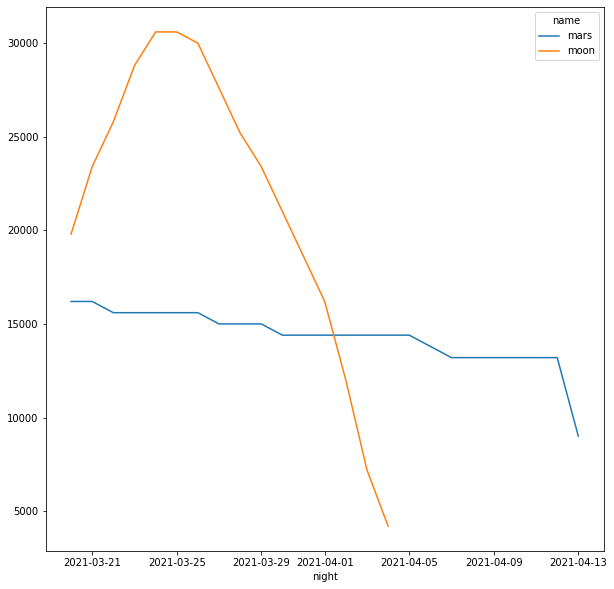

In [13]:
cal[cal["typev"]=="planet"].pivot(index="night",columns="name",values="dur").plot(figsize=(10,10))


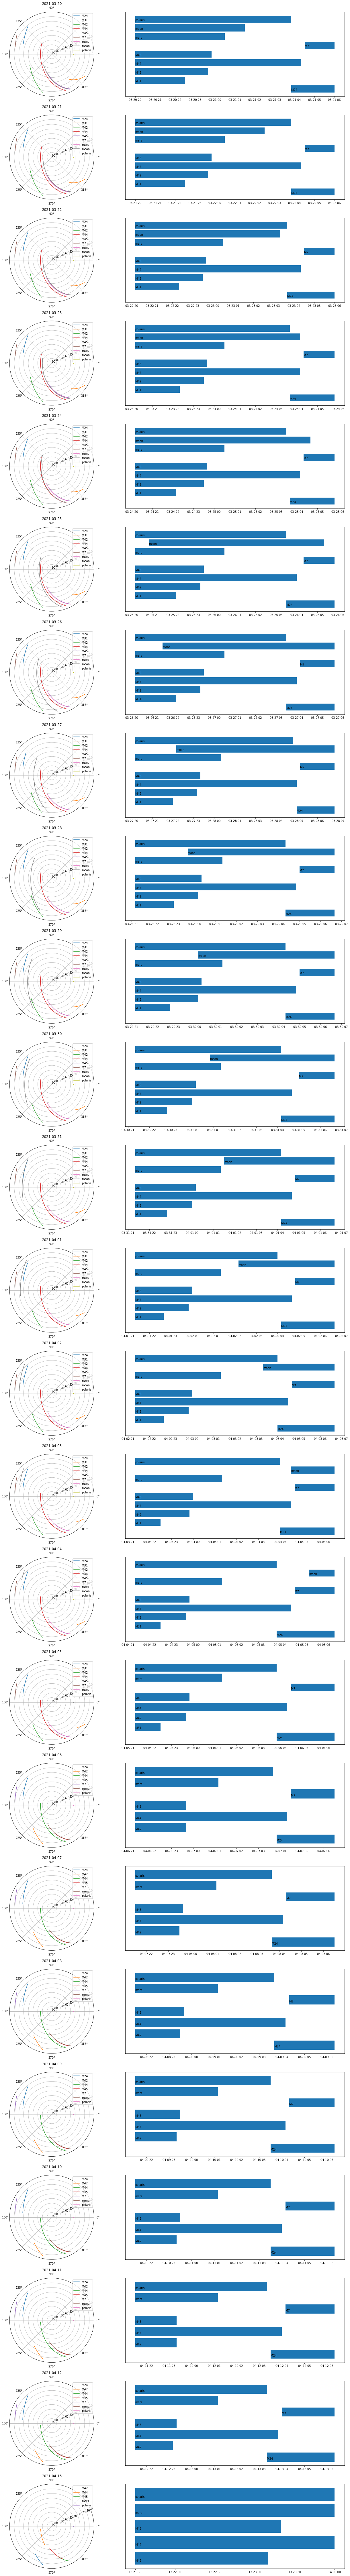

In [14]:
fig = plotCal(cal,df)

In [15]:
fig.savefig("./fig.png")

In [ ]:
def linksInfo(obj,typev):
    if obj == "moon":
        return "https://en.wikipedia.org/wiki/Moon"
    elif typev == "deep":
        return "https://en.wikipedia.org/wiki/Messier_%s"% obj.replace("M","")
    else :
        return "https://en.wikipedia.org/wiki/%s"%obj
    



In [ ]:
c = Calendar()
cgb = cal.groupby(["night","name"])
for name,g in cgb:
    #print(name,g)
    night,obj = name

    typev = g["typev"].values[0]
    
    
    e = Event()
    e.name = "%s"%obj
    
    e.begin = str(g["amin"].values[0])
    e.end = str(g["amax"].values[0])
    e.description = """%s Visible during %s Minutes

%s


%s %s  -> %s %s 
    
    
    """%(obj,int(g["dur"].values[0]/60.), linksInfo( obj, typev),
                                            g["alt_end"].values[0],g["az_end"].values[0],
                                            g["alt_start"].values[0],g["az_start"].values[0])
    
    #print(e.description)
    e.categories = ("scope", typev )
    c.events.add(e)


In [ ]:
# [<Event 'My cool event' begin:2014-01-01 00:00:00 end:2014-01-01 00:00:01>]
with open('./calendar.ics', 'w') as my_file:
    my_file.writelines(c)

In [87]:
!pip install ISS_Info

In [13]:
!pip install meteofrance-api

  Using cached pytz-2020.5-py2.py3-none-any.whl (510 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.1
    Uninstalling pytz-2021.1:
      Successfully uninstalled pytz-2021.1


In [15]:
from meteofrance_api import MeteoFranceClient
from meteofrance_api.helpers import readeable_phenomenoms_dict


mfc = MeteoFranceClient()

# Search a location from name.
list_places = mfc.search_places("TOulouse")


In [67]:
ftcst = mfc.get_forecast(lat,lon)


<AxesSubplot:xlabel='dt'>

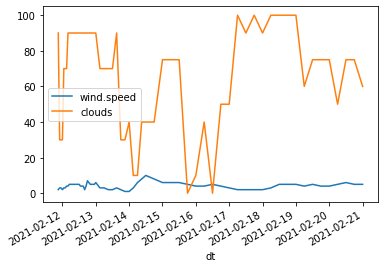

In [80]:
fcst = pd.json_normalize(ftcst.forecast)
fcst["dt"] = pd.to_datetime(fcst["dt"],unit="s",utc=True)
fcst.set_index("dt")[["wind.speed","clouds"]].plot()

In [81]:
fcst

,dt,humidity,sea_level,iso0,rain snow limit,clouds,T.value,T.windchill,wind.speed,wind.gust,wind.direction,wind.icon,rain.1h,snow.1h,weather.icon,weather.desc,rain.3h,snow.3h,rain.6h,snow.6h
0,2021-02-11 21:00:00+00:00,75,1017.5,2650,Non pertinent,90,11.7,11.10,2,0,110,ESE,0.0,0.0,p3n,Très nuageux,NaN,NaN,NaN,NaN
1,2021-02-11 22:00:00+00:00,75,1017.2,2700,Non pertinent,30,11.8,10.70,3,0,120,ESE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
2,2021-02-11 23:00:00+00:00,70,1016.9,2700,Non pertinent,30,11.5,10.00,3,0,115,ESE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
3,2021-02-12 00:00:00+00:00,90,1016.6,2700,Non pertinent,30,7.6,6.50,2,0,140,SE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
4,2021-02-12 01:00:00+00:00,90,1016.3,2500,Non pertinent,70,7.7,6.00,3,0,135,SE,0.0,0.0,p2n,Eclaircies,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2021-02-20 00:00:00+00:00,90,1023.8,1400,Non pertinent,75,7.8,5.29,4,0,135,SE,NaN,NaN,p2n,Eclaircies,NaN,NaN,0.0,0.0
63,2021-02-20 06:00:00+00:00,90,1023.2,1200,Non pertinent,50,6.7,3.45,5,0,90,E,NaN,NaN,p2n,Eclaircies,NaN,NaN,0.0,0.0
64,2021-02-20 12:00:00+00:00,65,1023.1,2200,Non pertinent,75,13.4,11.54,6,12,135,SE,NaN,NaN,p2j,Eclaircies,NaN,NaN,0.0,0.0
65,2021-02-20 18:00:00+00:00,80,1022.3,1800,Non pertinent,75,10.7,8.45,5,12,90,E,NaN,NaN,p2j,Eclaircies,NaN,NaN,0.0,0.0


<AxesSubplot:xlabel='dt'>

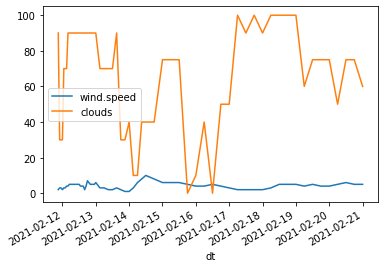

In [78]:
fcst

,dt,humidity,sea_level,iso0,rain snow limit,clouds,T.value,T.windchill,wind.speed,wind.gust,wind.direction,wind.icon,rain.1h,snow.1h,weather.icon,weather.desc,rain.3h,snow.3h,rain.6h,snow.6h
0,2021-02-11 21:00:00+00:00,75,1017.5,2650,Non pertinent,90,11.7,11.10,2,0,110,ESE,0.0,0.0,p3n,Très nuageux,NaN,NaN,NaN,NaN
1,2021-02-11 22:00:00+00:00,75,1017.2,2700,Non pertinent,30,11.8,10.70,3,0,120,ESE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
2,2021-02-11 23:00:00+00:00,70,1016.9,2700,Non pertinent,30,11.5,10.00,3,0,115,ESE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
3,2021-02-12 00:00:00+00:00,90,1016.6,2700,Non pertinent,30,7.6,6.50,2,0,140,SE,0.0,0.0,p4n,Ciel voilé,NaN,NaN,NaN,NaN
4,2021-02-12 01:00:00+00:00,90,1016.3,2500,Non pertinent,70,7.7,6.00,3,0,135,SE,0.0,0.0,p2n,Eclaircies,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2021-02-20 00:00:00+00:00,90,1023.8,1400,Non pertinent,75,7.8,5.29,4,0,135,SE,NaN,NaN,p2n,Eclaircies,NaN,NaN,0.0,0.0
63,2021-02-20 06:00:00+00:00,90,1023.2,1200,Non pertinent,50,6.7,3.45,5,0,90,E,NaN,NaN,p2n,Eclaircies,NaN,NaN,0.0,0.0
64,2021-02-20 12:00:00+00:00,65,1023.1,2200,Non pertinent,75,13.4,11.54,6,12,135,SE,NaN,NaN,p2j,Eclaircies,NaN,NaN,0.0,0.0
65,2021-02-20 18:00:00+00:00,80,1022.3,1800,Non pertinent,75,10.7,8.45,5,12,90,E,NaN,NaN,p2j,Eclaircies,NaN,NaN,0.0,0.0
